In [1]:
# https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

from io import open
import glob
import os
import unicodedata
import string
import torch.nn as nn
import random

In [2]:
def findFiles(path): return glob.glob(path)

data_path = '../../data/name_rnn/names/*.txt'

print(findFiles(data_path))

['../../data/name_rnn/names/Polish.txt', '../../data/name_rnn/names/Japanese.txt', '../../data/name_rnn/names/Arabic.txt', '../../data/name_rnn/names/Chinese.txt', '../../data/name_rnn/names/Russian.txt', '../../data/name_rnn/names/Czech.txt', '../../data/name_rnn/names/Vietnamese.txt', '../../data/name_rnn/names/German.txt', '../../data/name_rnn/names/Dutch.txt', '../../data/name_rnn/names/Greek.txt', '../../data/name_rnn/names/Italian.txt', '../../data/name_rnn/names/Spanish.txt', '../../data/name_rnn/names/Portuguese.txt', '../../data/name_rnn/names/Irish.txt', '../../data/name_rnn/names/French.txt', '../../data/name_rnn/names/Korean.txt', '../../data/name_rnn/names/Scottish.txt', '../../data/name_rnn/names/English.txt']


In [3]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

display(all_letters)

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'"

In [4]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [5]:
print(unicodeToAscii('Ślusàrski'))

Slusarski


In [6]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

In [7]:
# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles(data_path):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    
n_categories = len(all_categories)

In [8]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [9]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [10]:
print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


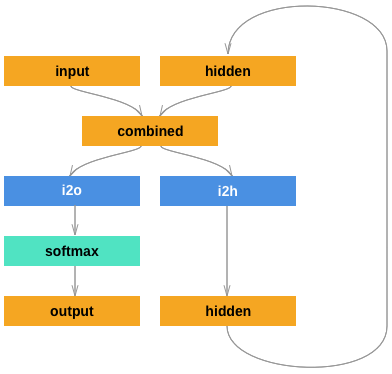

In [11]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.input_to_hidden_layer = nn.Linear(input_size + hidden_size, hidden_size)
        
        self.input_to_output_layer = nn.Sequential(
            nn.Linear(input_size + hidden_size, output_size),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        
        hidden = self.input_to_hidden_layer(combined)
        output = self.input_to_output_layer(combined)
        
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [12]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [13]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8828, -2.9243, -2.9360, -2.9774, -2.8972, -2.8806, -2.8674, -2.8920,
         -2.7941, -2.9520, -2.8301, -2.8718, -2.8395, -2.8294, -2.8526, -3.0067,
         -2.8762, -2.9427]], grad_fn=<LogSoftmaxBackward>)


In [14]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Dutch', 8)


In [15]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ category_tensor = ', category_tensor, '/ line =', line)

category = Scottish / category_tensor =  tensor([16]) / line = Jones
category = Japanese / category_tensor =  tensor([1]) / line = Tsumura
category = Arabic / category_tensor =  tensor([2]) / line = Shamon
category = Italian / category_tensor =  tensor([10]) / line = Nigro
category = Russian / category_tensor =  tensor([4]) / line = Ablesimoff
category = Scottish / category_tensor =  tensor([16]) / line = Alexander
category = Portuguese / category_tensor =  tensor([12]) / line = Barros
category = Chinese / category_tensor =  tensor([3]) / line = Shan
category = Spanish / category_tensor =  tensor([11]) / line = Vela
category = Irish / category_tensor =  tensor([13]) / line = Macghabhann


In [19]:
# Last layer is LogSoftmax.
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(rnn.parameters())

In [22]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.init_hidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    optimizer.step()

    return output, loss.item()

In [23]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 7s) 2.4758 Troon / Korean ✗ (English)
10000 10% (0m 15s) 3.3109 Driml / French ✗ (Czech)
15000 15% (0m 23s) 2.9390 Martel / Arabic ✗ (French)
20000 20% (0m 31s) 1.1060 Souza / Arabic ✗ (Portuguese)
25000 25% (0m 39s) 5.1294 Can / Chinese ✗ (Dutch)
30000 30% (0m 47s) 0.8772 Han / Vietnamese ✓
35000 35% (0m 54s) 1.4743 Gordon / Irish ✗ (Scottish)
40000 40% (1m 2s) 0.8170 Treblik / Czech ✓
45000 45% (1m 10s) 0.7450 Rios / Portuguese ✓
50000 50% (1m 18s) 2.5464 Jacques / Portuguese ✗ (French)
55000 55% (1m 26s) 0.7242 Nader / Arabic ✓
60000 60% (1m 35s) 1.0998 Cote / French ✓
65000 65% (1m 43s) 0.0919 Hiratasuka / Japanese ✓
70000 70% (1m 50s) 1.3155 Gibson / Scottish ✓
75000 75% (1m 58s) 1.3420 Andreu / French ✗ (Spanish)
80000 80% (2m 6s) 5.6026 Shikuk / Czech ✗ (Japanese)
85000 85% (2m 14s) 0.9784 Earle / English ✓
90000 90% (2m 23s) 1.3729 Watt / German ✗ (Scottish)
95000 95% (2m 31s) 2.1846 Young / Chinese ✗ (Scottish)
100000 100% (2m 39s) 2.7212 Kacirek / Polish ✗ (Czech)

In [25]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

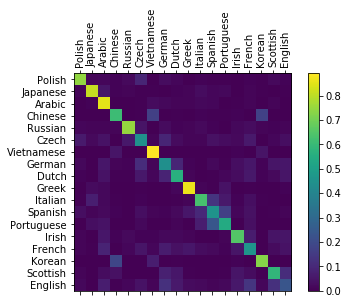

In [27]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.init_hidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()